# Домашнее задание 5. Линейные модели

In [136]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import sklearn.linear_model as lm
import sklearn.utils as su


# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = np.load("out_4.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

In [5]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [6]:
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

In [32]:
Y = df_users_train[df_users_train['uid'].isin(users)]['cat'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (4930x1033002) feature matrix, 4930 target vector


Убедимся, что распределение частоты признаков соответствует закону Ципфа:

X axis from 1 to 5357.0
Y axis from 0.5 to 720414.2


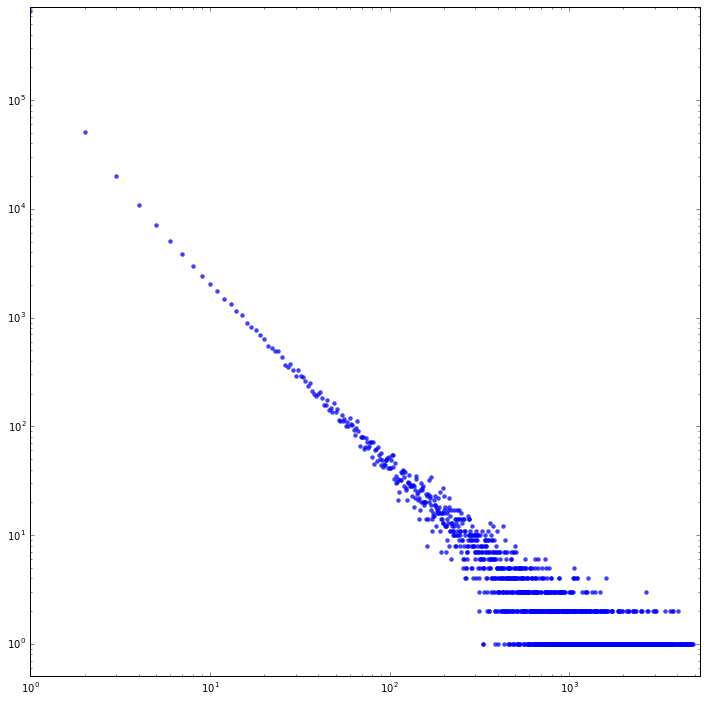

In [33]:
def draw_log_hist(X):
    features_counts = np.array((X > 0).sum(axis=0)).ravel() # frequency of each feature
    tmp_x, tmp_y = np.unique(features_counts, return_counts=True) # frequency and amount
    plt.figure(figsize=(12, 12))
    plt.xscale('log') # transform to log axis
    plt.yscale('log')
    plt.xlim(1, tmp_x.max() * 1.1)
    plt.ylim(0.5, tmp_y.max() * 1.1) # 0.5 for better visibility
    print "X axis from", 1, "to", tmp_x.max() * 1.1
    print "Y axis from", 0.5, "to", tmp_y.max() * 1.1
    plt.scatter(tmp_x, tmp_y, c = 'b', linewidths = 0, alpha = 0.75)
    plt.show()
    
    return features_counts.astype(np.int)

features_counts = draw_log_hist(X)

Отсеем действительно часто встречающиеся признаки (больше 100):

In [59]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

In [11]:
USER_NAME = "t.mubarakshin"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


In [12]:
def sigm_func(x):
    return 1.0 / (1.0 + np.exp(-x))

In [251]:
class LogisticRegression():
    
    def __init__(self, C = 1, max_it = 30000, eps = 0.001, step = 0.5):
        self.C = C
        self.max_it = max_it
        self.eps = eps
        self.step = step # not the real step, we use it for  eta = it_num ** (-step)
        
    def grad_desc(self, w0, X, Y, C):
        grad = np.dot(X,(sigm_func(np.dot(X.T, w0)) - Y))/ X.shape[0]
        grad += float(C) * np.abs(w0) / X.shape[0]
        return grad
        
    def fit(self, X, Y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        it_num = 1
        if Y.ndim == 1:
            Y = Y[:,np.newaxis]
        self.w0 = np.zeros((X.shape[1], 1)) # initial approximation
        while True:
            eta = it_num ** (-self.step)
            rand_num = pr.randint(0,X.shape[0]-1)
            X_new = X[rand_num]
            X_new = X_new[:,np.newaxis]
            grad = self.grad_desc(self.w0, X_new, Y[rand_num], self.C)
            self.w0 -= eta * grad
            it_num += 1
            if it_num > self.max_it or np.all(np.abs(eta * grad) < self.eps):
                break
        print "Iterations:",it_num
        
        return self
    
    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigm_func(np.dot(X, self.w0))

Функция, возвращающая TPR, FPR и площадь под ROC-кривой:

In [256]:
def auroc(y_prob, y_true):
    fpr, tpr, thresholds = sm.roc_curve(y_true, y_prob)
    return tpr, fpr, np.trapz(tpr, fpr)

Определим наилучший параметр регуляризации:

In [253]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]

def select_reg_parameter(C, X, Y):
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size = 0.2)
    best_score = 0
    for c in C:
        mod = LogisticRegression(c, eps = 0.00001)
        mod.fit(X_train, Y_train)
        probs = mod.predict_proba(X_test)
        print "Accuracy:",sm.accuracy_score(Y_test, np.round(probs).astype(int))
        tpr, fpr, cur_auc = auroc(probs, Y_test)
        if cur_auc > best_score:
            best_C = c
            best_score = cur_auc
        print "C:", c, "AUC:", cur_auc
        print '-'*30
    return C.index(best_C)

index = select_reg_parameter(C, X1, Y)
print index

Iterations: 378
Accuracy: 0.493914807302
C: 0.0 AUC: 0.50562875336
------------------------------
Iterations: 993
Accuracy: 0.490872210953
C: 0.01 AUC: 0.508975134699
------------------------------
Iterations: 993
Accuracy: 0.487829614604
C: 0.1 AUC: 0.508295979815
------------------------------
Iterations: 1209
Accuracy: 0.478701825558
C: 1 AUC: 0.481228570605
------------------------------
Iterations: 1891
Accuracy: 0.503042596349
C: 10 AUC: 0.530806877164
------------------------------
Iterations: 1616
Accuracy: 0.516227180527
C: 100 AUC: 0.510333444468
------------------------------
Iterations: 30001
Accuracy: 0.51014198783
C: 1000 AUC: 0.5
------------------------------
Iterations: 30001
Accuracy: 0.51014198783
C: 10000 AUC: 0.5
------------------------------
4


Ради интереса проверим работу классификатора из sklearn:

In [255]:
lg_sklearn = lm.LogisticRegression(penalty = 'l2', max_iter = 1000, solver = 'sag')
X_train, X_test, Y_train, Y_test = cv.train_test_split(X1, Y, test_size = 0.2)
lg_sklearn.fit(X_train, Y_train)
Y_pred = lg_sklearn.predict(X_test)
# print Y_pred
print sm.accuracy_score(Y_test, Y_pred)

0.496957403651


Проверим алгоритм с наилучшим параметром регуляризации на тренировочной выборке:

In [288]:
def classify(X, Y, test_size, C):
    X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size = test_size)
    lr = LogisticRegression(C, eps = 0.00001)
    lr.fit(X_train, Y_train)
    Y_prob = lr.predict_proba(X_test)
    tpr, fpr, roc_auc = auroc(Y_prob, Y_test)
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

Iterations: 777
Area under the ROC curve : 0.526097


И построим ROC-кривую:

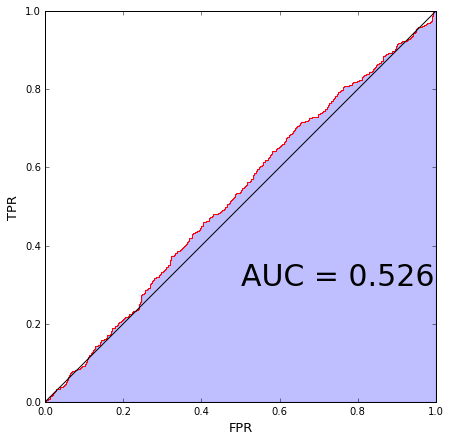

In [289]:
def plot_roc_curve(tpr, fpr, roc_auc):
    fig = plt.figure(figsize = (7, 7))
    ax = fig.add_subplot(111)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.plot(fpr, tpr, color='red')
    plt.plot([0, 1], [0, 1], color='black') # diagonal
    pl.fill_between(fpr, tpr, alpha=0.25, color='blue')
    pl.text(0.5, 0.3, "AUC = %0.3f" % roc_auc, fontsize=30)
    plt.xlabel("FPR", fontsize=13)
    plt.ylabel("TPR", fontsize=13)
    plt.show()
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

Теперь используем модель для классификации тестовых данных:

In [294]:
ex_users = df_users_ex['uid'].values
eix = np.in1d(users, ex_users).reshape(users.shape)
ex_X = X_dataset[np.where(eix)]
ex_X1 = ex_X.tocsc()[:, features_counts > 100].toarray()
print "Resulting test set: (%dx%d) feature matrix" % (ex_X1.shape[0], ex_X1.shape[1])

Resulting test set: (1873x6288) feature matrix


In [295]:
lr = LogisticRegression(C[index], eps = 0.00001)
lr.fit(X1, Y)
Y_pred = lr.predict_proba(ex_X1)

Iterations: 574


In [337]:
fpredict = open("predict.csv", "wt")
fpredict.write("uid,cat\n")
count = 0
for i in xrange(len(eix)):
    if eix[i]:
        fpredict.write(str(users[i]) + "," + str(float(Y_pred[count])) + "\n")
        count += 1
print "Total", count, "written."
print "Now add users without any info"
count = 0
for i in df_users_ex['uid']:
    if i not in users:
        fpredict.write(str(i) + "," + str(pr.random()) + "\n")
        count += 1
print "Total", count, "unknown users written."
fpredict.close()

Total 1873 written.
Now add users without any info
Total 25 unknown users written.
